# PD1 - Aleksander Malinowski

In [4]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, torch

# XOR data generation

Coords are generated from the uniform distribution on (-1,1) range

In [16]:
xCoord = np.random.uniform(-1,1,2000)
yCoord = np.random.uniform(-1,1,2000)
df = pd.DataFrame({'x':xCoord, 'y':yCoord})
df

,x,y
0,0.989829,-0.951927
1,-0.088236,0.994933
2,-0.248591,0.276554
3,0.497174,0.251519
4,0.065374,-0.286716
...,...,...
1995,-0.196313,0.297522
1996,0.825987,-0.883117
1997,0.650921,0.981386
1998,-0.655101,-0.016778


In [21]:
def xorVals(row):
    if (row['x'] > 0 and row['y'] > 0) or (row['x'] < 0 and row['y'] < 0):
        return 1
    else:
        return 0
    

In [22]:
df['val'] = df.apply(lambda x: xorVals(x), axis = 1)

<AxesSubplot:xlabel='x', ylabel='y'>

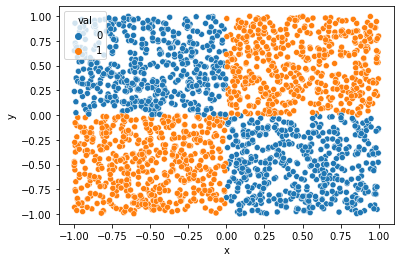

In [23]:
sns.scatterplot(x=df.x,y=df.y,hue=df.val)

# Creating and evaluating a naive model (simple classification without neural network functions from torch library)

In [115]:
num_inputs = 2
y = df.val
X = np.column_stack((df.x,df.y))
Y = np.column_stack((df.val, 1- df.val))
num_outputs = Y.shape[1]
X = torch.as_tensor(X, dtype=torch.float32)
Y = torch.as_tensor(Y, dtype=torch.float32)
W = torch.normal(0,0.15,size=(num_inputs,num_outputs), requires_grad = True)
b = torch.zeros(num_outputs,requires_grad = True)
torch.mm(X,W)

tensor([[-0.2385,  0.0437],
        [ 0.0846, -0.0064],
        [ 0.0625, -0.0111],
        ...,
        [-0.0449,  0.0243],
        [ 0.1128, -0.0271],
        [ 0.0690, -0.0267]], grad_fn=<MmBackward0>)

In [116]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])
def neural_network(X):
    return softmax(torch.mm(X.reshape((-1, W.shape[0])), W) + b)

In [117]:
optimizer = torch.optim.SGD({W, b}, lr=0.05)
errors = []
for i in range(500):
    y_hat = neural_network(X)
    errors += [np.abs((torch.as_tensor(y) - y_hat.argmax(1)).numpy()).mean()]
    l = cross_entropy(y_hat, y)
    optimizer.zero_grad()
    l.mean().backward()
    optimizer.step()
np.abs((torch.as_tensor(y) - y_hat.argmax(1)).numpy()).mean()

0.4865

<AxesSubplot:>

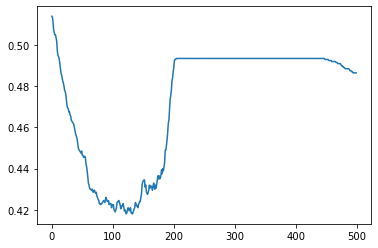

In [118]:
sns.lineplot(x=range(500),y=errors)

In [69]:
W

tensor([[ 0.0356,  0.0071],
        [-0.0360, -0.0263]], requires_grad=True)

In [70]:
b

tensor([-0.0127,  0.0127], requires_grad=True)

Naive model doesn't provide visible advantage over random choice of numbers, let's see what happens when MLP comes to play

# Torch's MLP models and evaluation

### First, let's split our data

In [96]:
from sklearn.model_selection import train_test_split

In [119]:
def split_data(df):
    feats = [feat for feat in df.columns if feat != 'val']
    
    X = df[feats]
    y = df['val']
    
    return X, y

In [162]:
X,y = split_data(df)
y = y.factorize()[0]
df_train, df_test = train_test_split(df[df.columns.values[:]],test_size=0.3, random_state=42,stratify=y)

### Now we're ready to create our first MLP, let's start from a compact combination of 2 hidden layers each containing 2 neurons

In [313]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.04)

In [199]:
net = torch.nn.Sequential(
    torch.nn.Linear(2, 2), 
    torch.nn.ReLU(),
    torch.nn.Linear(2,2), 
    torch.nn.ReLU(),
    torch.nn.Linear(2,2),
    torch.nn.Softmax(dim=1)
)


net.apply(init_weights)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=2, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2, out_features=2, bias=True)
  (5): Softmax(dim=1)
)

In [200]:
def model_training(net,epochs,lr,batch_size,optimizer,loss):
    dataloader_train = torch.utils.data.DataLoader(np.array(df_train), batch_size=1)
    dataloader_test = torch.utils.data.DataLoader(np.array(df_test), batch_size=1)
    losses = []
    errors_train = []
    errors_test = []
    for epoch in range(num_iter):
        losses_iter = []
        errors_train_iter = []
        errors_test_iter = []

        for data in dataloader_test:
            X, y = data[:,0:2],data[:,2].long()
            y_hat = net(X.float())
            errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

        for data in dataloader_train:
            X, y = data[:,0:2],data[:,2].long()
            y_hat = net(X.float())
            errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.mean().backward()
            losses_iter += [l.mean().item()]
            optimizer.step()

        errors_train += [np.mean(errors_train_iter)]
        errors_test += [np.mean(errors_test_iter)]
        losses += [np.mean(losses_iter)]
    data2plot = pd.DataFrame({'train':errors_train,'test':errors_test,'loss':losses})
    data2plot
    dfm = data2plot.reset_index().melt('index', var_name='cols',  value_name='vals')
    sns.catplot(x="index", y="vals", hue='cols', data=dfm, kind='point')

In [321]:
from sklearn.metrics import confusion_matrix
def conf_matrix(dataloader_test):
    y_pred = []
    y_true = []
    for data in dataloader_test:
        inputs, labels = data[:,0:2], data[:,2]
        output = net(inputs.float())
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)
    classes = ('0','1')
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *2, index = [i for i in classes],
                         columns = [i for i in classes])
    sns.heatmap(df_cm, annot=True, cmap="Blues")

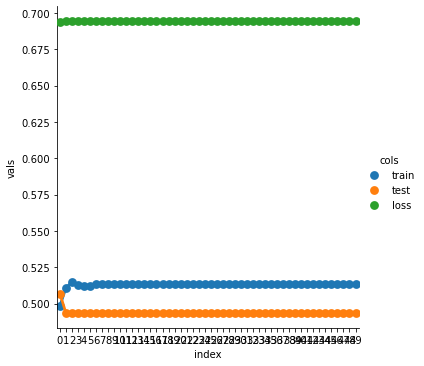

In [201]:
learning_rate = 0.03
num_iter = 50
batch_size = 256
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training(net,num_iter,learning_rate,batch_size,optimizer,loss)

Unfortunately, our net looks like it is a bit too small, but let's look at the learning curve, perhaps changing it will help. We'll try decreasing first, then increasing

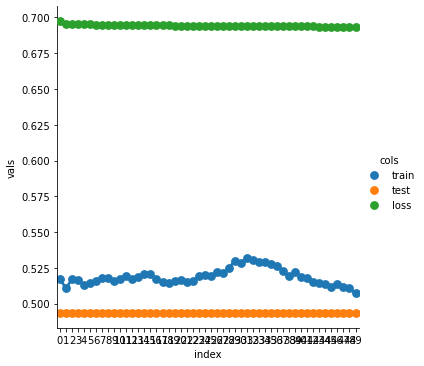

In [205]:
learning_rate = 0.01
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training(net,num_iter,learning_rate,batch_size,optimizer,loss)

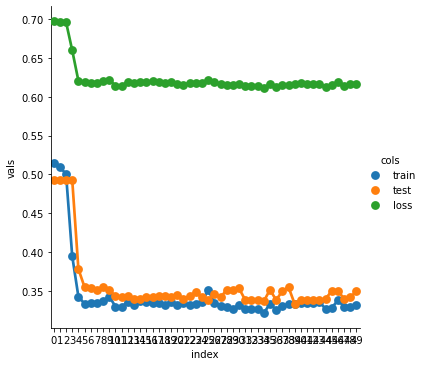

In [206]:
learning_rate = 0.09
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training(net,num_iter,learning_rate,batch_size,optimizer,loss)

With bigger learning rate, the net has managed to reach different minimum, which has resulted in reducing mean error, let's see how does a confusion matrix look like in this case:

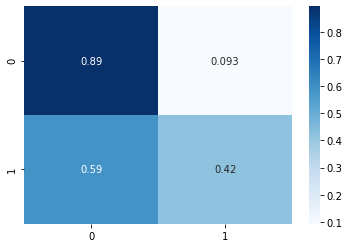

In [208]:
conf_matrix(dataloader_test)

Doesn't come very close to ideal fitting, so perhaps more epochs will help?

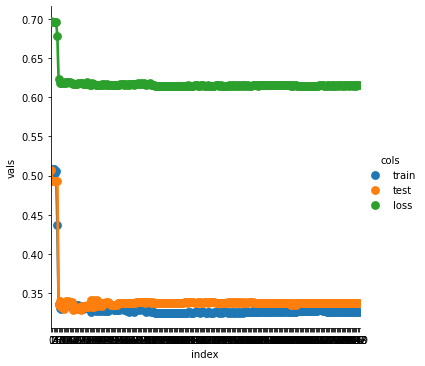

In [209]:
num_iter = 250
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training(net,num_iter,learning_rate,batch_size,optimizer,loss)

### It took a lot of time and provided no gain over 50 epochs. Not worth it, so let's just try a more complex MLP:

In [230]:
net = torch.nn.Sequential(
    torch.nn.Linear(2, 12), 
    torch.nn.ReLU(),
    torch.nn.Linear(12,8), 
    torch.nn.ReLU(),
    torch.nn.Linear(8,2)
)
net.apply(init_weights)

Sequential(
  (0): Linear(in_features=2, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=2, bias=True)
)

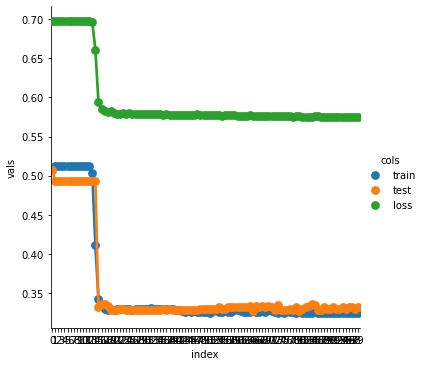

In [231]:
learning_rate = 0.03
num_iter = 100
batch_size = 256
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training(net,num_iter,learning_rate,batch_size,optimizer,loss)

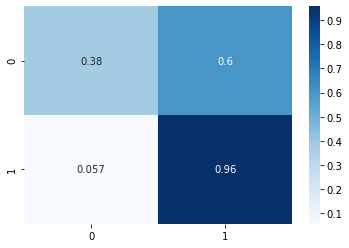

In [233]:
conf_matrix(dataloader_test)

There's a slight improvement, note that the number of iterations was increased, but it doesn't change much when it comes to score. Let's try different lrs:

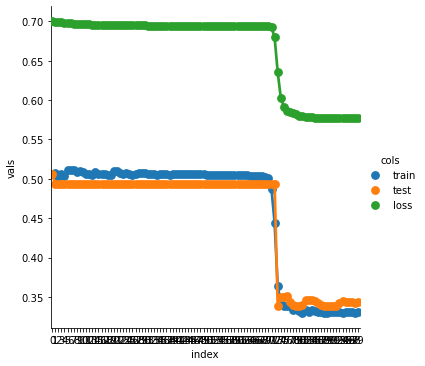

In [225]:
learning_rate = 0.01
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training(net,num_iter,learning_rate,batch_size,optimizer,loss)

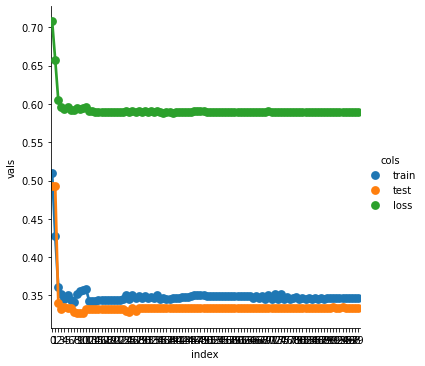

In [226]:
learning_rate = 0.09
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training(net,num_iter,learning_rate,batch_size,optimizer,loss)

Different lrs don't seem to make the score better, so I'm going to try increasing the number of epochs

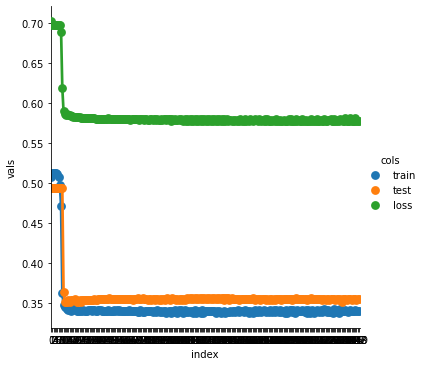

In [234]:
num_iter = 250
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training(net,num_iter,learning_rate,batch_size,optimizer,loss)

Well... perhaps it's still to small, let's check it!

### (Even more) Complex MLP

In [284]:
net = torch.nn.Sequential(
    torch.nn.Linear(2, 16), 
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16), 
    torch.nn.ReLU(),
    torch.nn.Linear(16, 2)
)

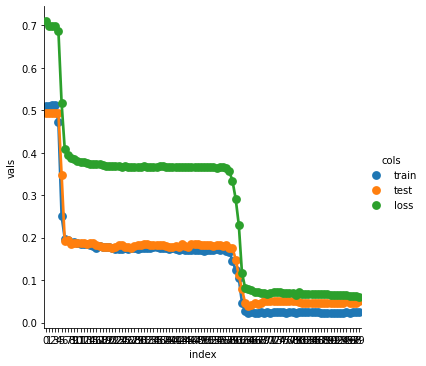

In [277]:
net.apply(init_weights)
learning_rate = 0.03
num_iter = 100
batch_size = 256
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training(net,num_iter,learning_rate,batch_size,optimizer,loss)

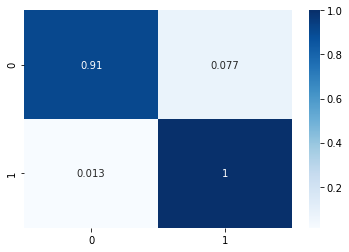

In [278]:
conf_matrix(dataloader_test)

Wow, we have finally achieved a good-looking model. Let's try with different lrs and numbers of epochs and see if there will be any changes (positive or negative)

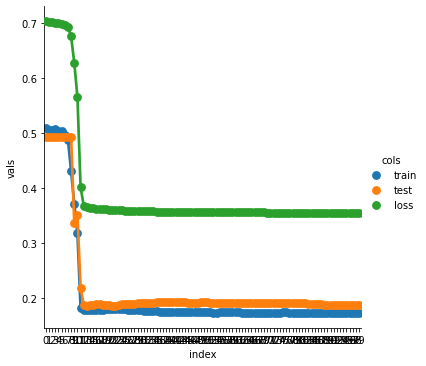

In [279]:
learning_rate = 0.01
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training(net,num_iter,learning_rate,batch_size,optimizer,loss)

Seems like we need more epochs to achieve the same results with smaller lr

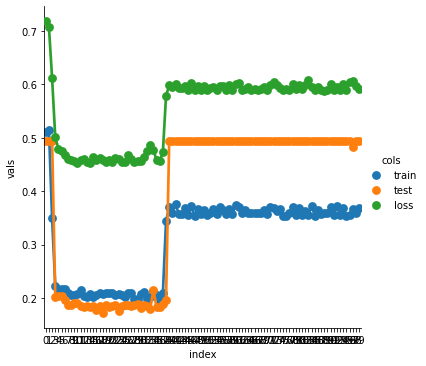

In [280]:
learning_rate = 0.09
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training(net,num_iter,learning_rate,batch_size,optimizer,loss)

We're seeing that at some point, our net took a wrong route, it's also heavily overfitted, we can expect that on the next plot too:

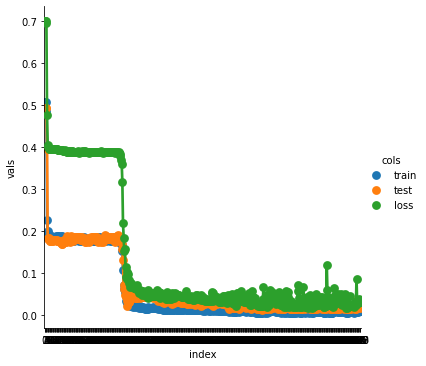

In [285]:
learning_rate = 0.04
num_iter = 500
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training(net,num_iter,learning_rate,batch_size,optimizer,loss)

Well, it's not as visible as on the previous plot, but certainly there's an epoch after which it makes no sense to train the net further as there's basically no improvement

### Conclusions:

* For the XOR data, network needs to be carefully fitted, because even the smallest changes can result in unpredictable behaviour
* It seems like the last net works quite good, but we're seeing an overfitting problem there
* Overally though, with well fitted parameters, MLP with 2 layers each containing 16 neurons is sufficient to correctly predict over 90% of the values

# Iris dataset

In [286]:
from sklearn.datasets import load_iris
iris = load_iris()
iris = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['val'])
iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),val
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


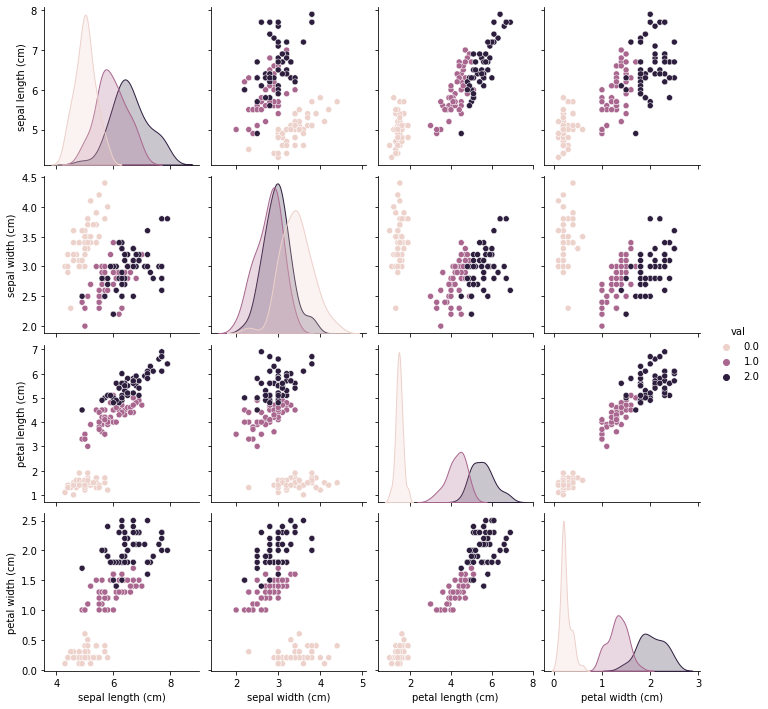

In [335]:
sns.pairplot(iris,hue='val')

In [331]:
def conf_matrix_iris(dataloader_test):
    y_pred = []
    y_true = []
    for data in dataloader_test:
        inputs, labels = data[:,0:4], data[:,4]
        output = net(inputs.float())
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)
    classes = ('0','1','2')
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *3, index = [i for i in classes],
                         columns = [i for i in classes])
    sns.heatmap(df_cm, annot=True, cmap="Blues")

In [287]:
def model_training_iris(net,epochs,lr,batch_size,optimizer,loss):
    dataloader_train = torch.utils.data.DataLoader(np.array(df_train), batch_size=1)
    dataloader_test = torch.utils.data.DataLoader(np.array(df_test), batch_size=1)
    losses = []
    errors_train = []
    errors_test = []
    for epoch in range(num_iter):
        losses_iter = []
        errors_train_iter = []
        errors_test_iter = []

        for data in dataloader_test:
            X, y = data[:,0:4],data[:,4].long()
            y_hat = net(X.float())
            errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

        for data in dataloader_train:
            X, y = data[:,0:4],data[:,4].long()
            y_hat = net(X.float())
            errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.mean().backward()
            losses_iter += [l.mean().item()]
            optimizer.step()

        errors_train += [np.mean(errors_train_iter)]
        errors_test += [np.mean(errors_test_iter)]
        losses += [np.mean(losses_iter)]
    data2plot = pd.DataFrame({'train':errors_train,'test':errors_test,'loss':losses})
    data2plot
    dfm = data2plot.reset_index().melt('index', var_name='cols',  value_name='vals')
    sns.catplot(x="index", y="vals", hue='cols', data=dfm, kind='point')

In [327]:
X,y = split_data(iris)
y = y.factorize()[0]
df_train, df_test = train_test_split(iris[iris.columns.values[:]],test_size=0.25, random_state=42,stratify=y)

### Functions and data are ready, let's begin with a small net with one hidden layer

In [364]:
net = torch.nn.Sequential(
    torch.nn.Linear(4, 3), 
    torch.nn.ReLU(),
    torch.nn.Linear(3, 3)
)

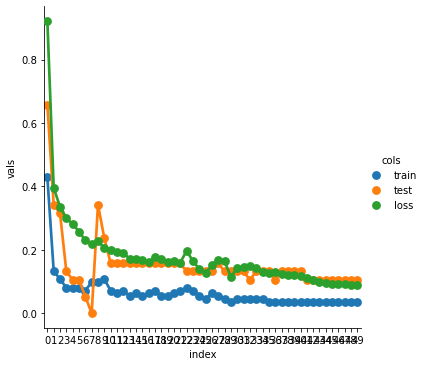

In [342]:
net.apply(init_weights)
learning_rate = 0.03
num_iter = 50
batch_size = 256
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training_iris(net,num_iter,learning_rate,batch_size,optimizer,loss)

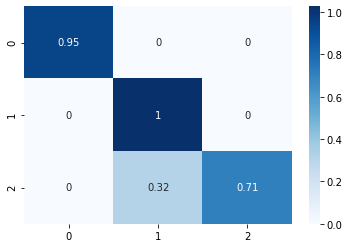

In [343]:
conf_matrix_iris(dataloader_test)

Results are quite satisfying, let's see how it looks with different lrs:

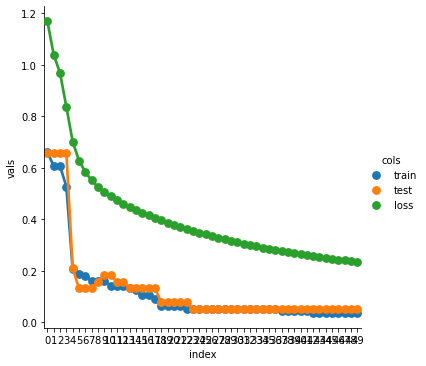

In [351]:
learning_rate = 0.01
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training_iris(net,num_iter,learning_rate,batch_size,optimizer,loss)

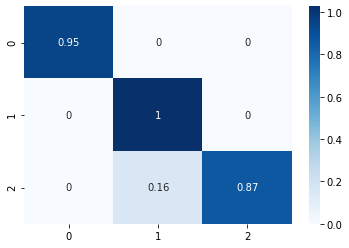

In [352]:
conf_matrix_iris(dataloader_test)

Even better!

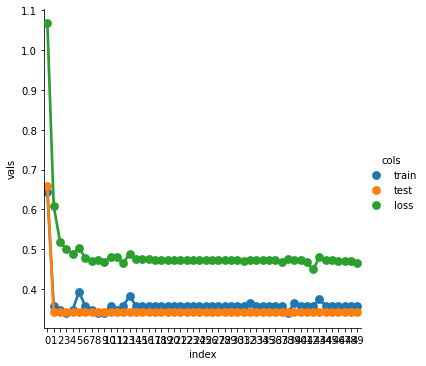

In [362]:
learning_rate = 0.09
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training_iris(net,num_iter,learning_rate,batch_size,optimizer,loss)

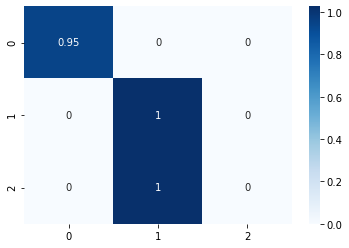

In [363]:
conf_matrix_iris(dataloader_test)

Increasing lr too much causes two class to be undistinctable for our network. Let's see what happens when we increase the number of epochs:

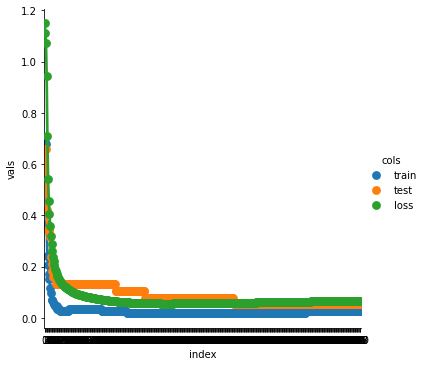

In [367]:
learning_rate = 0.01
num_iter = 450
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training_iris(net,num_iter,learning_rate,batch_size,optimizer,loss)

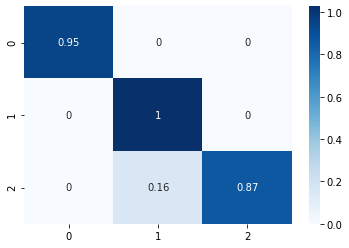

In [368]:
conf_matrix_iris(dataloader_test)

Further increase of epochs didn't give us any benefits, plus it took way longer than the earlier ones to train it

### If that MLP worked well, perhaps it can be further reduced?

In [389]:
net = torch.nn.Sequential(
    torch.nn.Linear(4, 2), 
    torch.nn.ReLU(),
    torch.nn.Linear(2, 3)
)

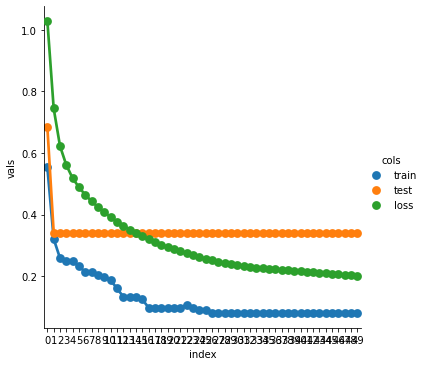

In [374]:
net.apply(init_weights)
learning_rate = 0.03
num_iter = 50
batch_size = 256
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training_iris(net,num_iter,learning_rate,batch_size,optimizer,loss)

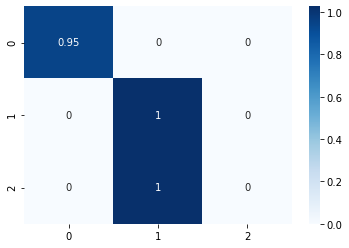

In [375]:
conf_matrix_iris(dataloader_test)

So the problem is, it fits our training set quite well, but it doesn't recognize 1's from 2's

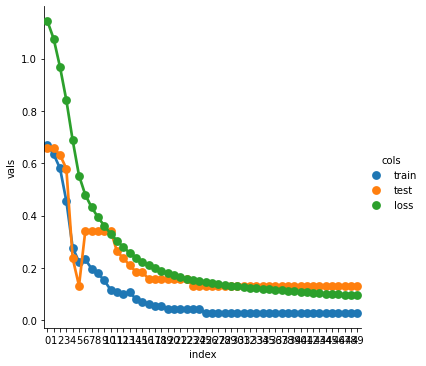

In [378]:
learning_rate = 0.01
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training_iris(net,num_iter,learning_rate,batch_size,optimizer,loss)

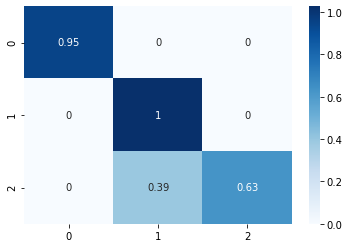

In [379]:
conf_matrix_iris(dataloader_test)

Wow, decreasing lr can sometimes do miracles! It's not a bad score for such a small net

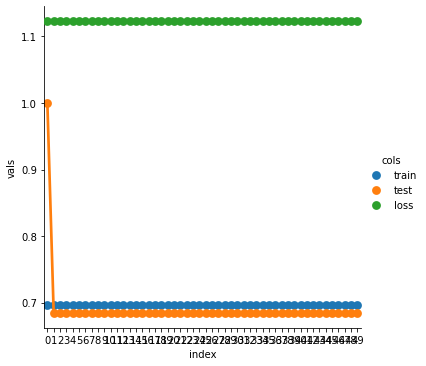

In [387]:
learning_rate = 0.09
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training_iris(net,num_iter,learning_rate,batch_size,optimizer,loss)

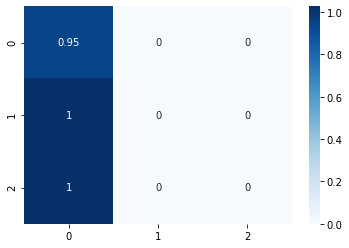

In [388]:
conf_matrix_iris(dataloader_test)

Makes no sense to increase lr in this case, it just classifies everything as 0

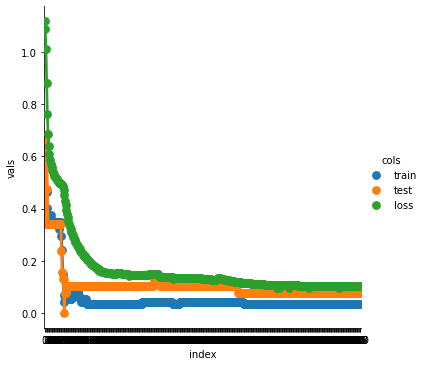

In [390]:
learning_rate = 0.01
num_iter = 450
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training_iris(net,num_iter,learning_rate,batch_size,optimizer,loss)

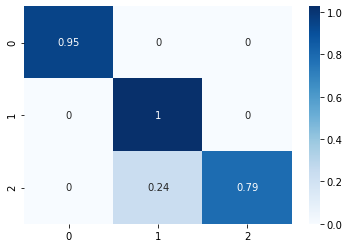

In [391]:
conf_matrix_iris(dataloader_test)

In this case, increasing the number of epochs resulted in slightly improved accuracy. Don't know if it's worth it, maybe if you have enough time

### Small MLPs work well, but how will a bigger one perform? Let's see:

In [412]:
net = torch.nn.Sequential(
    torch.nn.Linear(4, 12), 
    torch.nn.ReLU(),
    torch.nn.Linear(12, 8), 
    torch.nn.ReLU(),
    torch.nn.Linear(8, 3)
)

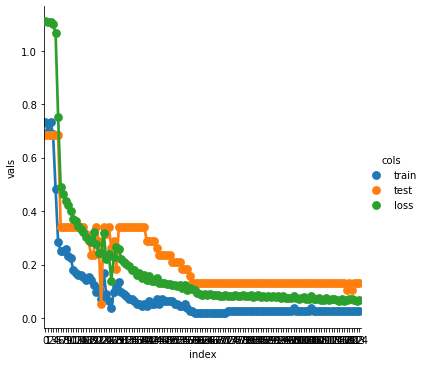

In [401]:
net.apply(init_weights)
learning_rate = 0.03
num_iter = 125
batch_size = 256
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training_iris(net,num_iter,learning_rate,batch_size,optimizer,loss)

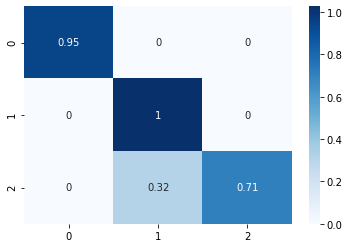

In [402]:
conf_matrix_iris(dataloader_test)

Not as impressive as we may have expected... Looks overfitted but maybe reducing lr will help as it did in the earlier cases

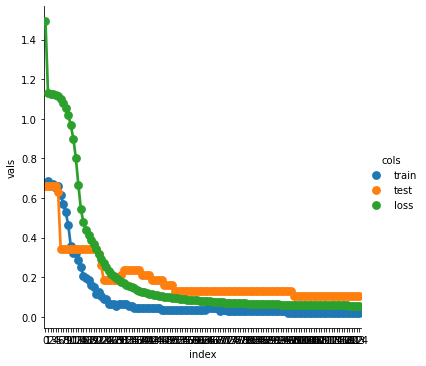

In [403]:
learning_rate = 0.01
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training_iris(net,num_iter,learning_rate,batch_size,optimizer,loss)

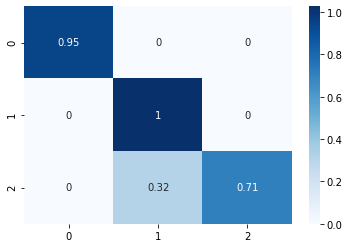

In [404]:
conf_matrix_iris(dataloader_test)

Unfortunately, this time the score is exactly equal with smaller lr. Perhaps a bigger one can finally prove itself?

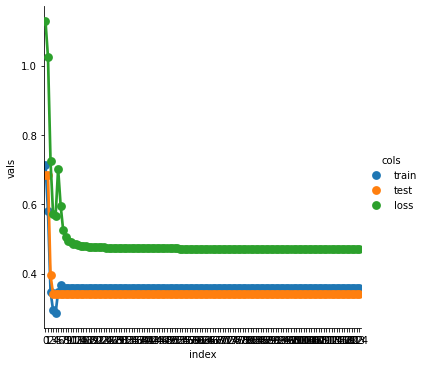

In [410]:
learning_rate = 0.09
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training_iris(net,num_iter,learning_rate,batch_size,optimizer,loss)

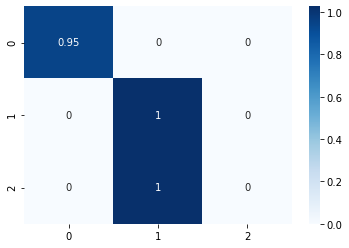

In [411]:
conf_matrix_iris(dataloader_test)

Old issues stay with us, greater lr results in unability to recognize 1's from 2's

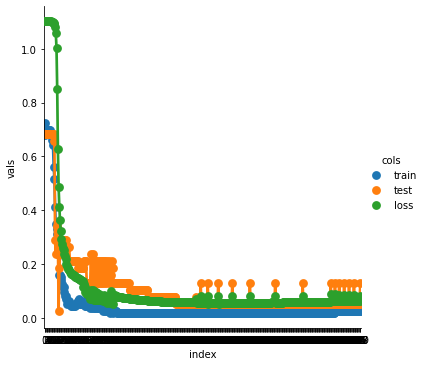

In [413]:
learning_rate = 0.01
num_iter = 450
net.apply(init_weights)
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
model_training_iris(net,num_iter,learning_rate,batch_size,optimizer,loss)

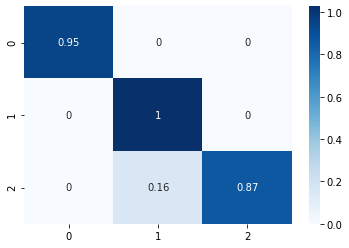

In [414]:
conf_matrix_iris(dataloader_test)

This one is quite unstable when it comes to later epochs, but all in all results in high accuracy. What is worth noticing, our first MLP achieved exactly the same score.

### Conclusions:

* For the iris data, learning rate is an important parameter, it should probably be quite low because otherwise classes 1 and 2 merge into each other
* The first network proved itself to be most accurate and compact of those 3. Adding another layer hasn't caused any increase of the score
* One hidden layer is sufficient in case of this dataset. It works well provided that the learning rate is properly adjusted

# Thanks for your attention!